# Classical Computing Approaches to the Traveling Salesman Problem

The approaches explored are
* Brute Force - Naive approach to solving the TSP. Yields optimal solution.
* Nearest Neighbor - The Hamiltonian path traversed is done through choosing the closest node to travel to next.
* Simulated Annealing - [Insert explanation]

In [9]:
import time

### Brute Force

This method is very computationally expensive. It solves the TSP in O(n!) time, where n is the number of nodes in the graph traversed

In [10]:
from sys import maxsize 
from itertools import permutations

# node = n
n = 4

# implementation of traveling Salesman Problem 
# takes a 2D array as input and a source node to start from.
def bruteForceTSP(graph, source): 

	# store all vertex apart from source vertex 
	arr_vertices = [] 
	for i in range(n): 
		if i != source: 
			arr_vertices.append(i) 

	# store minimum weight Hamiltonian Cycle 
	min_path = maxsize 
	# permutations function from itertools generates all possible permutations of arr_vertices
	all_permutations = permutations(arr_vertices)
	
    # iterate through all_permutation
	# loop calculates the weight of each permutation and updates min_path variable each time.
	for i in all_permutations:

		# store current Path weight(cost) 
		curr_path_weight = 0

		# compute current path weight 
		k = source 
		for j in i: 
			curr_path_weight += graph[k][j] 
			k = j 
		curr_path_weight += graph[k][source] 

		# update minimum 
		min_path = min(min_path, curr_path_weight) 
		
	return min_path 

In [11]:
# matrix representation of graph 
graph = [[0, 10, 15, 20], [10, 0, 35, 25], 
		[15, 35, 0, 30], [20, 25, 30, 0]] 
s = 0

start = time.time()
print("The minimum Hamiltonian path is: ",bruteForceTSP(graph, s))
end = time.time()

time_taken = end - start
print("Time taken: ", time_taken)

The minimum Hamiltonian path is:  80
Time taken:  0.0


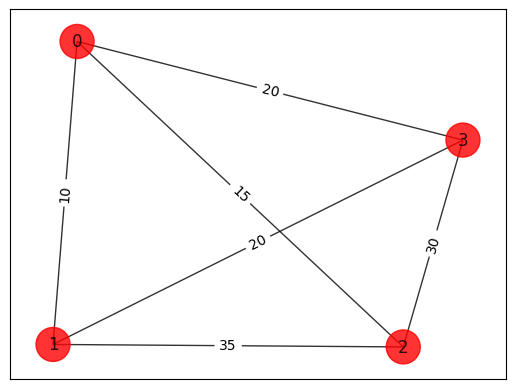

In [12]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 10), (0, 2, 15), (0, 3, 20), (1, 2, 35), (1, 3, 20), (2, 3, 30)]
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

### Nearest Neighbor and Simulated Annealing

In [46]:
import math
import random
import matplotlib.pyplot as plt


class classical_TSP(object):
    def __init__(self, coords, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        self.coords = coords
        self.N = len(coords)
        self.T = math.sqrt(self.N) if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        self.alpha = 0.995 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1

        self.nodes = [i for i in range(self.N)]

        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []

    # find the TSP using the Nearest Neighbor approach
    def nearest_neighbor(self):
        start = time.time()
        curr_node = random.choice(self.nodes)  # start from a random node
        solution = [curr_node]

        # each iteration remove the current node from the array of free nodes
        free_nodes = set(self.nodes)
        free_nodes.remove(curr_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.calculate_distance(curr_node, x))  # nearest neighbour
            free_nodes.remove(next_node)
            solution.append(next_node)
            curr_node = next_node

        cur_fit = self.total_path_distance(solution)
        if cur_fit < self.best_fitness:  # If best found so far, update best fitness
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        end = time.time()
        print("Time taken:", end - start)
        print("Best fitness obtained: ", self.best_fitness)

        return solution, cur_fit

    # Calulcates the distance between two nodes
    def calculate_distance(self, node1, node2):
        coord1, coord2 = self.coords[node1], self.coords[node2]
        distance = math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2)
        return distance
    
    # Calulcates the total distance of the current path
    def total_path_distance(self, solution):
        total_distance = 0
        for i in range(self.N):
            total_distance += self.calculate_distance(solution[i % self.N], solution[(i + 1) % self.N])
        return total_distance
    
    # Plot the greedy solution.
    def plot_greedy_solution(self):
        solution, _ = self.nearest_neighbor()
        plotTSP([solution], self.coords)


    # Probability of accepting if the candidate is worse than the current solution.
    # Dependant on current temperature and difference between current and candidate.
    def p_accept(self, candidate_fitness):
        return math.exp(-abs(candidate_fitness - self.cur_fitness) / self.T)

    # If candidate is better than current, accept with probability = 1.
    # If candidate is worse, except with probability found in p_accept()

    def accept(self, candidate):
        candidate_fitness = self.total_path_distance(candidate)
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < self.p_accept(candidate_fitness):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate

    # Perform simulated annealing algorithm
    def simulated_annealing(self):
        start = time.time()
        # Initialize with the nearest neighbor solution.
        self.cur_solution, self.cur_fitness = self.nearest_neighbor()

        print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            candidate = list(self.cur_solution)
            l = random.randint(2, self.N - 1)
            i = random.randint(0, self.N - l)
            candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
            self.accept(candidate)
            self.T *= self.alpha
            self.iteration += 1

           # self.fitness_list.append(self.cur_fitness)
        end = time.time()
        print("Time taken: ", end - start)
        print("Best fitness obtained: ", self.best_fitness)
        # improvement = 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        # print(f"Improvement over greedy heuristic: {improvement : .2f}%")
                
    # def simulated_annealing(self):
    #     start = time.time()
    #     # Initialize with a random solution.
    #     self.cur_solution = list(range(self.N))
    #     self.cur_fitness = self.total_path_distance(self.cur_solution)

    #     print("Starting annealing.")
    #     while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
    #         candidate = list(self.cur_solution)  # Make a copy of the current solution
    #         l = random.randint(2, self.N - 1)
    #         i = random.randint(0, self.N - l)
    #         candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
    #         self.accept(candidate)
    #         self.T *= self.alpha
    #         self.iteration += 1
        
    #     end = time.time()
    #     print("Time taken: ", end - start)

    #     print("Best fitness obtained: ", self.best_fitness)



    # Runs a simulated annealing algorithm n time, with random initial solutions.
    def batch_anneal(self, n=10):
        for i in range(1, n + 1):
            print(f"Iteration {i}/{n} -------------------------------")
            self.T = self.T_save
            self.iteration = 1
            self.cur_solution, self.cur_fitness = self.nearest_neighbor()
            self.simulated_annealing()

    # Plot the route
    def visualize_routes(self):
        plotTSP([self.best_solution], self.coords)

    # Plot the learning
    def plot_learning(self):
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel("Fitness")
        plt.xlabel("Iteration")
        plt.show()



In [47]:
def plotTSP(paths, points, num_iters=1):
    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list

    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []
    y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for     this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []
            yi = []
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                      head_width=a_scale, color='r',
                      length_includes_head=True, ls='dashed',
                      width=0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                          head_width=a_scale, color='r', length_includes_head=True,
                          ls='dashed', width=0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width=a_scale,
              color='g', length_includes_head=True)
    for i in range(0, len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width=a_scale,
                  color='g', length_includes_head=True)

    # Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.show()


Time taken: 0.0
Best fitness obtained:  6032.897297600318
Starting annealing.
Time taken:  0.06246614456176758
Best fitness obtained:  5288.4371741409195


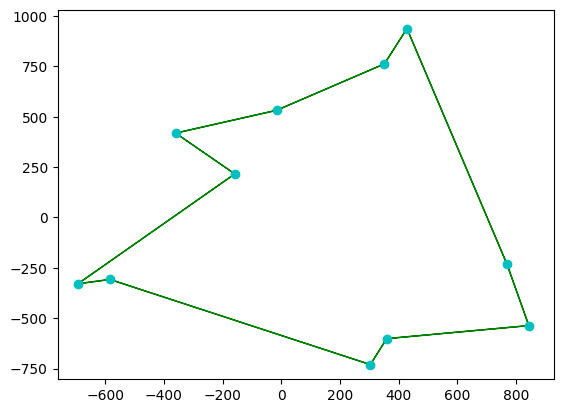

Nearest Neighbor Plot
Time taken: 0.0
Best fitness obtained:  6130.3055702978


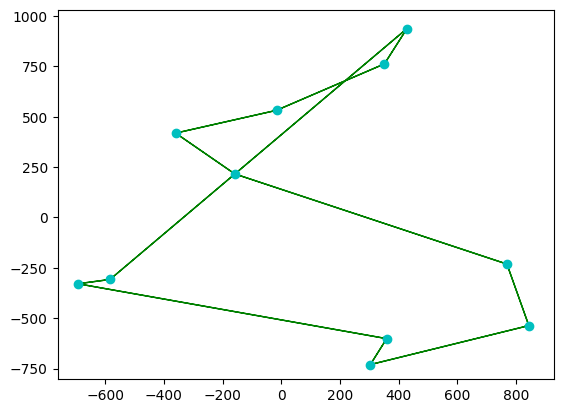

In [50]:
def read_coords(path):
    coords = []
    with open(path, "r") as f:
        for line in f.readlines():
            line = [float(x.replace("\n", "")) for x in line.split(" ")]
            coords.append(line)
    return coords


def generate_random_coords(num_nodes):
    return [[random.uniform(-1000, 1000), random.uniform(-1000, 1000)] for i in range(num_nodes)]


# coords = read_coords("coord.txt")  # generate_random_coords(100)
coords = generate_random_coords(11)
sa = classical_TSP(coords, stopping_iter=5000)
sa.simulated_annealing()
sa.visualize_routes()

#sa.plot_learning()

print("Nearest Neighbor Plot")
greedy = classical_TSP(coords, stopping_iter=5000)
greedy.plot_greedy_solution()


In [ ]:
import timeit

# Define a function to run the nearest neighbor method
def run_nearest_neighbor():
    sa = classical_TSP(coords)  # Initialize the TSP object
    start_time = timeit.default_timer()  # Record the start time
    sa.nearest_neighbor()  # Run the nearest neighbor method
    end_time = timeit.default_timer()  # Record the end time
    return end_time - start_time  # Return the elapsed time

# Set up your problem with coordinates
coords = generate_random_coords(100)  # Example: 100 random coordinates

# Measure the execution time of the nearest neighbor method
execution_time = run_nearest_neighbor()

print("Nearest neighbor method took {:.6f} seconds.".format(execution_time))
